In [2]:
#Importing the basic librarires

import os
import math
import scipy
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression

import warnings 
warnings.filterwarnings('ignore')


In [3]:
#Importing the dataset

df = pd.read_csv('../input/test-file/tested.csv')
df.drop(['PassengerId','Name','Ticket','Cabin'],axis=1, inplace=True)

target = 'Survived'
labels = ['Not-Survived','Survived']
features = [i for i in df.columns.values if i not in [target]]

original_df = df.copy(deep=True)
display(df.head())

print('\n\033[1mInference:\033[0m The Datset consists of {} features & {} samples.'.format(df.shape[1], df.shape[0]))

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,34.5,0,0,7.8292,Q
1,1,3,female,47.0,1,0,7.0000,S
2,0,2,male,62.0,0,0,9.6875,Q
3,0,3,male,27.0,0,0,8.6625,S
4,1,3,female,22.0,1,1,12.2875,S



Inference: The Datset consists of 8 features & 418 samples.


In [4]:
#Checking number of unique rows in each feature

df.nunique().sort_values()

Survived      2
Sex           2
Pclass        3
Embarked      3
SibSp         7
Parch         8
Age          79
Fare        169
dtype: int64

In [5]:
#Checking number of unique rows in each feature

nu = df[features].nunique().sort_values()
nf = []; cf = []; nnf = 0; ncf = 0; #numerical & categorical features

for i in range(df[features].shape[1]):
    if nu.values[i]<=15:cf.append(nu.index[i])
    else: nf.append(nu.index[i])

print('\n\033[1mInference:\033[0m The Datset has {} numerical & {} categorical features.'.format(len(nf),len(cf)))


Inference: The Datset has 2 numerical & 5 categorical features.


In [6]:
#Checking the stats of all the columns

display(df.describe())

,Survived,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,0.363636,2.265550,30.272590,0.447368,0.392344,35.627188
std,0.481622,0.841838,14.181209,0.896760,0.981429,55.907576
min,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,0.000000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1.000000,3.000000,76.000000,8.000000,9.000000,512.329200


# Data Preprocessing

In [11]:
#Removal of any Duplicate rows (if any)

counter = 0
r,c = original_df.shape

df1 = df.copy()
df1.drop_duplicates(inplace=True)
df1.reset_index(drop=True,inplace=True)

if df1.shape==(r,c):
    print('\n\033[1mInference:\033[0m The dataset doesn\'t have any duplicates')
else:
    print(f'\n\033[1mInference:\033[0m Number of duplicates dropped ---> {r-df1.shape[0]}')


Inference: Number of duplicates dropped ---> 38


In [12]:
#Check for empty elements

nvc = pd.DataFrame(df1.isnull().sum().sort_values(), columns=['Total Null Values'])
nvc['Percentage'] = round(nvc['Total Null Values']/df1.shape[0],3)*100
print(nvc)

          Total Null Values  Percentage
Survived                  0         0.0
Pclass                    0         0.0
Sex                       0         0.0
SibSp                     0         0.0
Parch                     0         0.0
Embarked                  0         0.0
Fare                      1         0.3
Age                      58        15.3


**Inference:** There are many outliers in the dataset. Let us try to impute the missing values

In [13]:
#Converting categorical Columns to Numeric

#df1 = df.copy()
ecc = nvc[nvc['Percentage']!=0].index.values
dcc = [i for i in df.columns if i not in ecc]

#Target Variable
MAP={}
for i,e in enumerate(df1[target].unique()):
    MAP[e]=i
df1[target]=df1[target].map(MAP)
print('Mapping Target variable --->',MAP)

df3 = df1[dcc]
fcc = [i for i in cf if i not in ecc]

#One-Hot Binay Encoding
oh=True
dm=True
for i in fcc:
    #print(i)
    if df3[i].nunique()==2:
        if oh==True: print("\033[1m\nOne-Hot Encoding on features:\033[0m")
        print(i);oh=False
        df3[i]=pd.get_dummies(df3[i], drop_first=True, prefix=str(i))
    if (df3[i].nunique()>2 and df3[i].nunique()<17):
        if dm==True: print("\n\033[1mDummy Encoding on features:\033[0m")
        print(i);dm=False
        df3 = pd.concat([df3.drop([i], axis=1), pd.DataFrame(pd.get_dummies(df3[i], drop_first=True, prefix=str(i)))],axis=1)
        
df3.shape

Mapping Target variable ---> {0: 0, 1: 1}

One-Hot Encoding on features:
Sex

Dummy Encoding on features:
Pclass
Embarked
SibSp
Parch


(380, 19)

In [14]:
# Fixing Empty Categorical Columns

for x in [i for i in ecc if i in cf]:
    a = df1[x]
    b=[]; c=[]

    for i,e in enumerate(a):
        if e!=e:
            b.append(i)
        else:
            c.append(i)

    RF = RandomForestClassifier()
    RF.fit(df3.loc[c],a[c])
    d = RF.predict(df3.loc[b])

    df3[x] = a
    f=0
    for i,e in enumerate(df3[x]):
        if e!=e:
            df3.loc[i,x] = d[f]
            f+=1
    df3 = pd.concat([df3.drop([x], axis=1), pd.DataFrame(pd.get_dummies(df3[x], drop_first=True, prefix=str(x)))],axis=1)   
df3

,Survived,Sex,Pclass_2,Pclass_3,Embarked_Q,Embarked_S,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Parch_9
0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,1,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
376,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
377,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
378,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [15]:
# Fixing Empty Numerical Columns

for x in [i for i in ecc if i not in cf]:
    a = df1[x]
    b=[]; c=[]

    for i,e in enumerate(a):
        if e!=e:
            b.append(i)
        else:
            c.append(i)

    LR = LinearRegression()
    LR.fit(df3.loc[c],a[c])
    d = LR.predict(df3.loc[b])

    df3[x] = a
    f=0
    for i,e in enumerate(df3[x]):
        if e!=e:
            df3.loc[i,x] = d[f]
            f+=1
    #df3 = pd.concat([df3.drop([x], axis=1), pd.DataFrame(pd.get_dummies(df3[x], drop_first=True, prefix=str(x)))],axis=1)   
df3

,Survived,Sex,Pclass_2,Pclass_3,Embarked_Q,Embarked_S,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Parch_9,Fare,Age
0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7.8292,34.500000
1,1,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,7.0000,47.000000
2,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9.6875,62.000000
3,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,8.6625,27.000000
4,1,0,0,1,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,12.2875,22.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,90.0000,37.000000
376,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,7.7750,28.000000
377,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,108.9000,39.000000
378,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,7.2500,38.500000


In [16]:
#Removal of outlier:

df4 = df3.copy()

for i in [i for i in df4.columns]:
    if df4[i].nunique()>=12:
        Q1 = df4[i].quantile(0.20)
        Q3 = df4[i].quantile(0.80)
        IQR = Q3 - Q1
        df4 = df4[df4[i] <= (Q3+(1.5*IQR))]
        df4 = df4[df4[i] >= (Q1-(1.5*IQR))]
df4 = df4.reset_index(drop=True)
display(df4.head())
print('\n\033[1mInference:\033[0m Before removal of outliers, The dataset had {} samples.'.format(df1.shape[0]))
print('\033[1mInference:\033[0m After removal of outliers, The dataset now has {} samples.'.format(df4.shape[0]))

,Survived,Sex,Pclass_2,Pclass_3,Embarked_Q,Embarked_S,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Parch_9,Fare,Age
0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7.8292,34.5
1,1,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,7.0000,47.0
2,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9.6875,62.0
3,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,8.6625,27.0
4,1,0,0,1,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,12.2875,22.0



Inference: Before removal of outliers, The dataset had 380 samples.
Inference: After removal of outliers, The dataset now has 350 samples.


# Training and testing

In [19]:
#Splitting the data intro training & testing sets

df = df5.copy()

X = df.drop([target],axis=1)
Y = df[target]
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=0)

print('Original set  ---> ',X.shape,Y.shape,'\nTraining set  ---> ',Train_X.shape,Train_Y.shape,'\nTesting set   ---> ', Test_X.shape,'', Test_Y.shape)

Original set  --->  (448, 20) (448,) 
Training set  --->  (358, 20) (358,) 
Testing set   --->  (90, 20)  (90,)


In [20]:
#Feature Scaling (Standardization)

std = StandardScaler()

print('\033[1mStandardardization on Training set'.center(100))
Train_X_std = std.fit_transform(Train_X)
Train_X_std = pd.DataFrame(Train_X_std, columns=X.columns)
display(Train_X_std.describe())

print('\n','\033[1mStandardardization on Testing set'.center(100))
Test_X_std = std.transform(Test_X)
Test_X_std = pd.DataFrame(Test_X_std, columns=X.columns)
display(Test_X_std.describe())

                               Standardardization on Training set                               


,Sex,Pclass_2,Pclass_3,Embarked_Q,Embarked_S,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Parch_9,Fare,Age
count,3.580000e+02,3.580000e+02,3.580000e+02,3.580000e+02,3.580000e+02,3.580000e+02,3.580000e+02,3.580000e+02,3.580000e+02,358.0,3.580000e+02,3.580000e+02,3.580000e+02,358.0,3.580000e+02,3.580000e+02,3.580000e+02,3.580000e+02,3.580000e+02,3.580000e+02
mean,2.208041e-16,8.125096e-17,2.573981e-17,-3.876477e-17,-2.000262e-16,-1.798685e-17,2.172378e-16,-2.022746e-16,-2.605768e-16,0.0,-1.792095e-16,-2.629802e-16,1.482365e-16,0.0,-8.981797e-17,-1.989796e-16,-1.546714e-17,-3.151576e-16,-3.132193e-17,3.746227e-16
std,1.001400e+00,1.001400e+00,1.001400e+00,1.001400e+00,1.001400e+00,1.001400e+00,1.001400e+00,1.001400e+00,1.001400e+00,0.0,1.001400e+00,1.001400e+00,1.001400e+00,0.0,1.001400e+00,1.001400e+00,1.001400e+00,1.001400e+00,1.001400e+00,1.001400e+00
min,-1.063462e+00,-5.364418e-01,-1.022602e+00,-3.133042e-01,-1.332364e+00,-5.665979e-01,-1.862313e-01,-7.495317e-02,-7.495317e-02,0.0,-5.292561e-02,-3.596353e-01,-2.432521e-01,0.0,-5.292561e-02,-5.292561e-02,-5.292561e-02,-7.495317e-02,-1.145002e+00,-2.236342e+00
25%,-1.063462e+00,-5.364418e-01,-1.022602e+00,-3.133042e-01,-1.332364e+00,-5.665979e-01,-1.862313e-01,-7.495317e-02,-7.495317e-02,0.0,-5.292561e-02,-3.596353e-01,-2.432521e-01,0.0,-5.292561e-02,-5.292561e-02,-5.292561e-02,-7.495317e-02,-7.433972e-01,-6.303328e-01
50%,9.403247e-01,-5.364418e-01,9.778978e-01,-3.133042e-01,7.505457e-01,-5.665979e-01,-1.862313e-01,-7.495317e-02,-7.495317e-02,0.0,-5.292561e-02,-3.596353e-01,-2.432521e-01,0.0,-5.292561e-02,-5.292561e-02,-5.292561e-02,-7.495317e-02,-4.361798e-01,-2.448290e-01
75%,9.403247e-01,-5.364418e-01,9.778978e-01,-3.133042e-01,7.505457e-01,-5.665979e-01,-1.862313e-01,-7.495317e-02,-7.495317e-02,0.0,-5.292561e-02,-3.596353e-01,-2.432521e-01,0.0,-5.292561e-02,-5.292561e-02,-5.292561e-02,-7.495317e-02,1.855320e-01,6.032793e-01
max,9.403247e-01,1.864135e+00,9.778978e-01,3.191786e+00,7.505457e-01,1.764920e+00,5.369668e+00,1.334166e+01,1.334166e+01,0.0,1.889444e+01,2.780595e+00,4.110961e+00,0.0,1.889444e+01,1.889444e+01,1.889444e+01,1.334166e+01,3.989676e+00,2.685000e+00



                                Standardardization on Testing set                                


,Sex,Pclass_2,Pclass_3,Embarked_Q,Embarked_S,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Parch_9,Fare,Age
count,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,9.000000e+01,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,9.000000e+01,9.000000e+01,9.000000e+01,9.000000e+01,90.000000,90.000000
mean,-0.306476,-0.163019,0.177698,-0.001741,-0.105762,0.055140,-1.862313e-01,0.074120,0.223194,0.011111,0.157601,0.093954,0.288929,0.011111,-5.292561e-02,-5.292561e-02,-5.292561e-02,-7.495317e-02,-0.041295,-0.188093
std,0.976942,0.874924,0.985531,1.003078,1.030607,1.036812,2.232886e-16,1.414236,1.988763,0.105409,1.997228,1.110100,1.434179,0.105409,2.093330e-17,2.093330e-17,2.791107e-17,1.814220e-16,0.997889,0.981451
min,-1.063462,-0.536442,-1.022602,-0.313304,-1.332364,-0.566598,-1.862313e-01,-0.074953,-0.074953,0.000000,-0.052926,-0.359635,-0.243252,0.000000,-5.292561e-02,-5.292561e-02,-5.292561e-02,-7.495317e-02,-1.114871,-2.191623
25%,-1.063462,-0.536442,-1.022602,-0.313304,-1.332364,-0.566598,-1.862313e-01,-0.074953,-0.074953,0.000000,-0.052926,-0.359635,-0.243252,0.000000,-5.292561e-02,-5.292561e-02,-5.292561e-02,-7.495317e-02,-0.745349,-0.784534
50%,-1.063462,-0.536442,0.977898,-0.313304,0.750546,-0.566598,-1.862313e-01,-0.074953,-0.074953,0.000000,-0.052926,-0.359635,-0.243252,0.000000,-5.292561e-02,-5.292561e-02,-5.292561e-02,-7.495317e-02,-0.450895,-0.321930
75%,0.940325,-0.536442,0.977898,-0.313304,0.750546,1.764920,-1.862313e-01,-0.074953,-0.074953,0.000000,-0.052926,-0.359635,-0.243252,0.000000,-5.292561e-02,-5.292561e-02,-5.292561e-02,-7.495317e-02,0.184505,0.383383
max,0.940325,1.864135,0.977898,3.191786,0.750546,1.764920,-1.862313e-01,13.341664,13.341664,1.000000,18.894444,2.780595,4.110961,1.000000,-5.292561e-02,-5.292561e-02,-5.292561e-02,-7.495317e-02,3.267821,2.685000


---

**Inference:** In VIF, RFE & PCA Techniques, we did notice any better scores upon dropping some multicollinear features. But in order to avoid the curse of dimensionality, we can capture top 90% of the data Variance explained by top 33 PCA components.

In [26]:
#Finalising the shortlisted features

rfe = RFE(LR,n_features_to_select=len(Train_X_std.columns)-0)   
rfe = rfe.fit(Train_X_std, Train_Y)

print(f1_score(Test_Y,LogisticRegression().fit(Train_X_std[Train_X_std.columns[rfe.support_]], Train_Y).predict(Test_X_std[Train_X_std.columns[rfe.support_]]),average='weighted')*100)
print(f1_score(Test_Y,RandomForestClassifier().fit(Train_X_std[Train_X_std.columns[rfe.support_]], Train_Y).predict(Test_X_std[Train_X_std.columns[rfe.support_]]),average='weighted')*100)
print(f1_score(Test_Y,XGBClassifier().fit(Train_X_std[Train_X_std.columns[rfe.support_]], Train_Y, eval_metric='logloss').predict(Test_X_std[Train_X_std.columns[rfe.support_]]),average='weighted')*100)
    
Train_X_std = Train_X_std[Train_X_std.columns[rfe.support_]]
Test_X_std = Test_X_std[Test_X_std.columns[rfe.support_]]

print(Train_X_std.shape)
print(Test_X_std.shape)

100.0
100.0
100.0
(358, 20)
(90, 20)


---

# Predictive Modeling

In [28]:
#Let us define functions to summarise the Prediction's scores .

#Classification Summary Function
def Classification_Summary(pred,pred_prob,i):
    Evaluation_Results.iloc[i]['Accuracy']=round(accuracy_score(Test_Y, pred),3)*100   
    Evaluation_Results.iloc[i]['Precision']=round(precision_score(Test_Y, pred, average='weighted'),3)*100 #
    Evaluation_Results.iloc[i]['Recall']=round(recall_score(Test_Y, pred, average='weighted'),3)*100 #
    Evaluation_Results.iloc[i]['F1-score']=round(f1_score(Test_Y, pred, average='weighted'),3)*100 #
    Evaluation_Results.iloc[i]['AUC-ROC score']=round(roc_auc_score(Test_Y, pred_prob[:,1], multi_class='ovr'),3)*100 #[:, 1]
    print('{}{}\033[1m Evaluating {} \033[0m{}{}\n'.format('<'*3,'-'*35,Evaluation_Results.index[i], '-'*35,'>'*3))
    print('Accuracy = {}%'.format(round(accuracy_score(Test_Y, pred),3)*100))
    print('F1 Score = {}%'.format(round(f1_score(Test_Y, pred, average='weighted'),3)*100)) #
    print('\n \033[1mConfusiton Matrix:\033[0m\n',confusion_matrix(Test_Y, pred))
    print('\n\033[1mClassification Report:\033[0m\n',classification_report(Test_Y, pred))
    
    auc_roc(Test_Y, pred_prob, curves=['each_class'])
    plt.show()

#Visualising Function
def AUC_ROC_plot(Test_Y, pred):    
    ref = [0 for _ in range(len(Test_Y))]
    ref_auc = roc_auc_score(Test_Y, ref)
    lr_auc = roc_auc_score(Test_Y, pred)

    ns_fpr, ns_tpr, _ = roc_curve(Test_Y, ref)
    lr_fpr, lr_tpr, _ = roc_curve(Test_Y, pred)

    plt.plot(ns_fpr, ns_tpr, linestyle='--')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='AUC = {}'.format(round(roc_auc_score(Test_Y, pred)*100,2))) 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

---

## 1. Logistic Regression:

<<<----------------------------------- Evaluating Logistic Regression (LR) ----------------------------------->>>

Accuracy = 100.0%
F1 Score = 100.0%

 Confusiton Matrix:
 [[34  0]
 [ 0 56]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        34
           1       1.00      1.00      1.00        56

    accuracy                           1.00        90
   macro avg       1.00      1.00      1.00        90
weighted avg       1.00      1.00      1.00        90



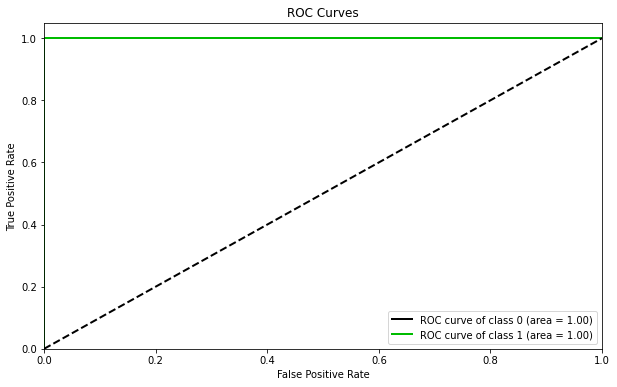


Interpreting the Output of Logistic Regression:

intercept  -0.14353748060054633
classes [0 1]


,coeff
Sex,-0.854289
Pclass_2,-0.086329
Pclass_3,-0.013769
Embarked_Q,0.029628
Embarked_S,-0.063585
SibSp_1,0.036549
SibSp_2,0.008374
SibSp_3,-0.041902
SibSp_4,-0.049206
SibSp_5,0.000000


In [29]:
# Building Logistic Regression Classifier

LR_model = LogisticRegression()

space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['l2'] #'none', 'l1', 'l2', 'elasticnet'
space['C'] = loguniform(1e-5, 100)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

RCV = RandomizedSearchCV(LR_model, space, n_iter=50, scoring='roc_auc', n_jobs=-1, cv=5, random_state=1)

LR = RCV.fit(Train_X_std, Train_Y).best_estimator_
pred = LR.predict(Test_X_std)
pred_prob = LR.predict_proba(Test_X_std)
Classification_Summary(pred,pred_prob,0)

print('\n\033[1mInterpreting the Output of Logistic Regression:\n\033[0m')

print('intercept ', LR.intercept_[0])
print('classes', LR.classes_)
display(pd.DataFrame({'coeff': LR.coef_[0]}, index=Train_X_std.columns))

## 3. Random Forest Classfier:

<<<----------------------------------- Evaluating Random Forest Classifier (RF) ----------------------------------->>>

Accuracy = 100.0%
F1 Score = 100.0%

 Confusiton Matrix:
 [[34  0]
 [ 0 56]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        34
           1       1.00      1.00      1.00        56

    accuracy                           1.00        90
   macro avg       1.00      1.00      1.00        90
weighted avg       1.00      1.00      1.00        90



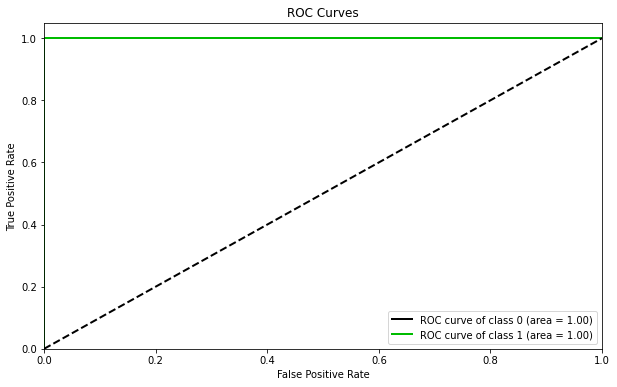


Interpreting the output of Random Forest:



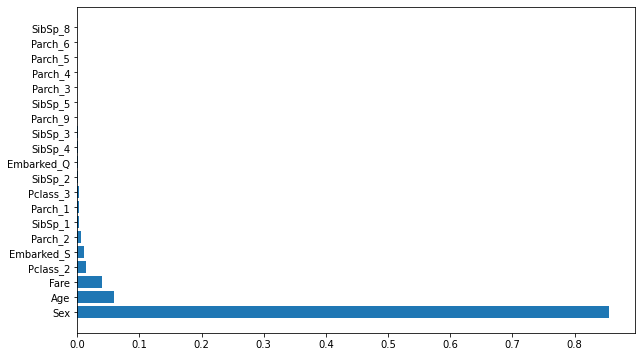

In [31]:
# Building Random-Forest Classifier

RF_model = RandomForestClassifier()

param_dist={'bootstrap': [True, False],
            'max_depth': [10, 20, 50, 100, None],
            'max_features': ['auto', 'sqrt'],
            'min_samples_leaf': [1, 2, 4],
            'min_samples_split': [2, 5, 10],
            'n_estimators': [50, 100]}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

RCV = RandomizedSearchCV(RF_model, param_dist, n_iter=50, scoring='roc_auc', n_jobs=-1, cv=5, random_state=1)

RF = RCV.fit(Train_X_std, Train_Y).best_estimator_
pred = RF.predict(Test_X_std)
pred_prob = RF.predict_proba(Test_X_std)
Classification_Summary(pred,pred_prob,2)

print('\n\033[1mInterpreting the output of Random Forest:\n\033[0m')
rfi=pd.Series(RF.feature_importances_, index=Train_X_std.columns).sort_values(ascending=False)
plt.barh(rfi.index,rfi.values)
plt.show()

## 6. K-Nearest Neighbours Classfier:

<<<----------------------------------- Evaluating K Nearest Neighbours (KNN) ----------------------------------->>>

Accuracy = 100.0%
F1 Score = 100.0%

 Confusiton Matrix:
 [[34  0]
 [ 0 56]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        34
           1       1.00      1.00      1.00        56

    accuracy                           1.00        90
   macro avg       1.00      1.00      1.00        90
weighted avg       1.00      1.00      1.00        90



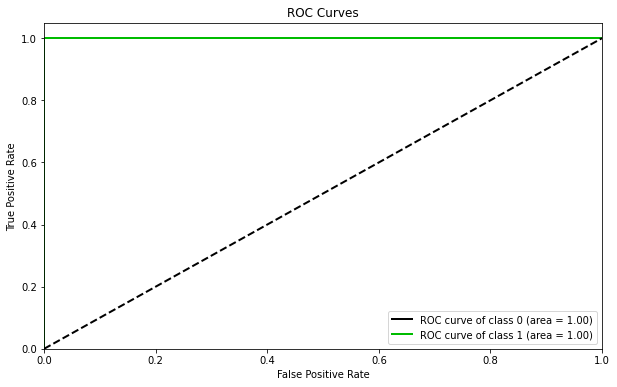

In [34]:
# Building K-Neareset Neighbours Classifier

KNN_model = KNeighborsClassifier()

knn_param = {"n_neighbors": [i for i in range(1,30,5)],
             "weights": ["uniform", "distance"],
             "algorithm": ["ball_tree", "kd_tree", "brute"],
             "leaf_size": [1, 10, 30],
             "p": [1,2]}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

RCV = RandomizedSearchCV(KNN_model, knn_param, n_iter=50, scoring='roc_auc', n_jobs=-1, cv=5, random_state=1)

KNN = RCV.fit(Train_X_std, Train_Y).best_estimator_
pred = KNN.predict(Test_X_std)
pred_prob = KNN.predict_proba(Test_X_std)
Classification_Summary(pred,pred_prob,5)